# Exploring QVEC

I want to spend some time now looking closer at QVEC's output, namely the correlations and the alignment matrix. The second main point of the original paper is that the alignments allow you to interpret individual dimensions of embeddings.

In [67]:
%matplotlib inline
import os
import csv
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

data_path = '../../data'
tmp_path = '../../tmp'

/home/bacon/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Linguistic features

In [2]:
feature_path = os.path.join(data_path, 'evaluation/semcor/tsvetkov_semcor.csv')
subset = pd.read_csv(feature_path, index_col=0)
subset.columns = [c.replace('semcor.', '') for c in subset.columns]
subset.set_index('words', inplace=True)
subset = subset.T

### Learnt embeddings

In [3]:
size = 300
fname = 'embeddings/glove.6B.{}d.txt'.format(size)
embedding_path = os.path.join(data_path, fname)
embeddings = pd.read_csv(embedding_path, sep=' ', header=None, index_col=0, quoting=csv.QUOTE_NONE).T

### QVEC model

In [4]:
def qvec(features, embeddings):
    """
    Returns correlations between columns of `features` and `embeddings`.
    
    The aligned feature is the one with the highest correlation.
    The qvec score is the sum of correlations of aligned features.
    """
    common_words = embeddings.columns.intersection(features.columns)
    S = features[common_words]
    X = embeddings[common_words]
    correlations = pd.DataFrame({i:X.corrwith(S.iloc[i], axis=1) for i in range(len(S))})
    correlations.columns = S.index
    return correlations

In [5]:
correlations = qvec(subset, embeddings)
V = len(embeddings.columns.intersection(subset.columns))

In [6]:
correlations.head()

,noun.Tops,noun.act,noun.animal,noun.artifact,noun.attribute,noun.body,noun.cognition,noun.communication,noun.event,noun.feeling,...,verb.consumption,verb.contact,verb.creation,verb.emotion,verb.motion,verb.perception,verb.possession,verb.social,verb.stative,verb.weather
1,-0.025195,0.103305,0.022804,0.019960,-0.005073,-0.063040,0.001746,-0.044627,0.060426,-0.000629,...,-0.000923,0.032615,-0.059228,0.002191,0.043395,0.016654,-0.000253,0.015861,-0.058195,0.027505
2,0.025052,0.003521,0.071996,0.033976,0.046986,0.000275,-0.025890,-0.093323,0.013002,-0.026363,...,0.041451,0.004752,0.008058,-0.024316,-0.043428,0.021968,-0.003188,0.024070,0.064498,-0.034473
3,0.000335,0.132868,-0.020388,-0.043322,0.026484,-0.031252,0.051305,0.025105,0.069223,0.112211,...,-0.009357,-0.078781,-0.096304,-0.000102,-0.010545,-0.015110,-0.082116,-0.047947,-0.098220,0.008797
4,0.003880,0.020326,0.023546,-0.164084,-0.013492,-0.079157,0.008527,0.045884,-0.002118,-0.003778,...,0.031046,-0.015342,-0.029799,0.009851,0.045801,-0.023565,0.036102,0.003050,0.059049,-0.009769
5,0.011347,0.032593,0.008034,-0.031921,-0.015440,0.030811,0.026431,-0.020380,-0.054214,0.032733,...,-0.006414,-0.024326,-0.012067,0.045959,-0.026189,-0.051913,0.013840,-0.012455,0.000732,-0.006095


## Exploration

#### What dimensions and features are aligned?

The dataframe below is as follows: index is the dimension of the learnt embedding, 'feature' is the name of the linguistic feature aligned with that dimension, and 'max_corr' is the correlation between the dimension and feature. The sum of the 'max_corr' column is the qvec score.

In [14]:
alignments = pd.DataFrame(correlations.idxmax(axis=1))
alignments.columns = ['feature']
alignments['max_corr'] = correlations.max(axis=1)
alignments.tail()

,feature,max_corr
296,noun.group,0.153578
297,noun.artifact,0.112932
298,noun.person,0.130420
299,noun.body,0.084260
300,noun.person,0.215958


#### What is QVEC doing?

QVEC is looking at 41 correlation coefficients (or as many linguistic features as there are) and finding the maximum. Here, I show the relevant scatterplot for the highest correlation.

A consistent observation is that the distribution of the linguistic features are strongly peaked at 0. That is, almost all words have 0 for for most features. Sometimes, there is some mass at 1. This suggests to me that the linguistic features being used are not appropriate.

In [11]:
common_words = embeddings.columns.intersection(subset.columns)
S = subset[common_words]
X = embeddings[common_words]
def plot(i, j):
    """Plot ith dimension of embeddings against feature j."""
    x = X.loc[i]
    s = S.loc[j]
    sns.jointplot(x, s);

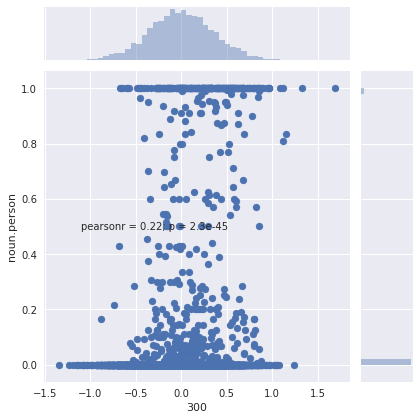

In [19]:
plot(300,'noun.person')

#### What do the learnt embeddings looks like?

**In sum: each dimension looks pretty normal, but the formal tests I'm using suggest otherwise. Most are centered at 0 with std around 0.4.**

From the marginal distribution plots above, it looks like each dimension is normally distributed. I don't know if that's purposively done during training or if it just turns out that way.

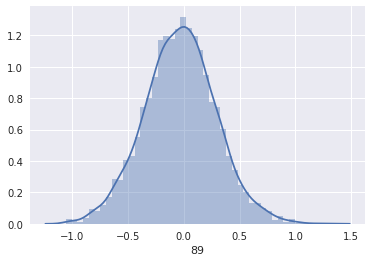

In [30]:
sns.distplot(X.loc[89]);

#### Graphical test of normality

I'm plotting a QQ plot and a probability plot side by side.

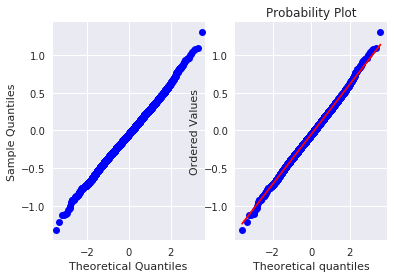

In [86]:
fig, axs = plt.subplots(1,2)
vector = X.loc[1]
sm.qqplot(vector, ax=axs[0]);
stats.probplot(vector, plot=axs[1]);

#### KS test

The preliminary results suggest that some dimensions are not normally distributed.

The KS test is clear, but I have some uncertainty about how to use it in scipy. In particular, do I give it the std or var of the distribution being tested? 

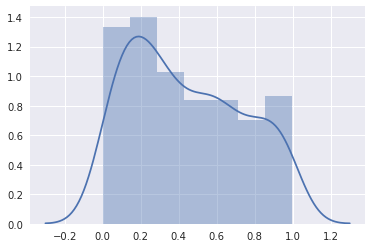

In [60]:
def do_kstest(i):
    vector = X.loc[i]
    ybar = vector.mean()
    s = vector.std()
    result = stats.kstest(vector, cdf='norm', args=(ybar, s))
    return result.pvalue

p_values = [do_kstest(i) for i in X.index]
sns.distplot(p_values);

#### Shapiro-Wilk test

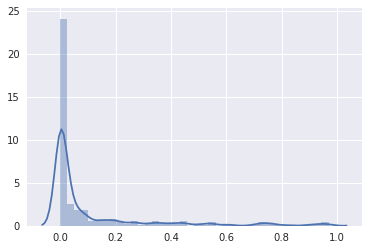

In [64]:
def do_shapirotest(i):
    vector = X.loc[i]
    result = stats.shapiro(vector)
    return result[1]

p_values = [do_shapirotest(i) for i in X.index]
sns.distplot(p_values);

#### Lilliefors test

In [75]:
def do_lillieforstest(i):
    vector = X.loc[i]
    result = sm.stats.lilliefors(vector)
    return result[1]

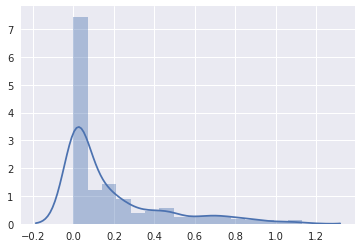

In [76]:
p_values = [do_lillieforstest(i) for i in X.index]
sns.distplot(p_values);

#### Location & spread of each dimension

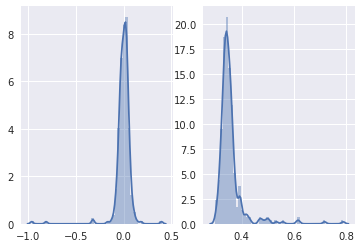

In [136]:
fig, axs = plt.subplots(1,2)
sns.distplot(X.mean(axis=1), ax=axs[0]);
sns.distplot(X.std(axis=1), ax=axs[1]);

#### What does each learnt embedding look like?

**In sum: Centered at 0 with std 0.4, but less clearly normal.**

How to answer this effectively?

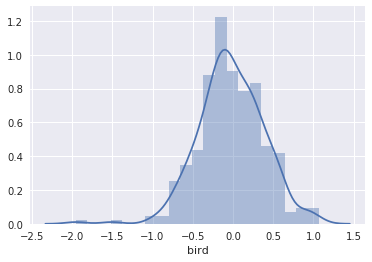

In [98]:
sns.distplot(X['bird']);

#### Location & spread of each word embedding

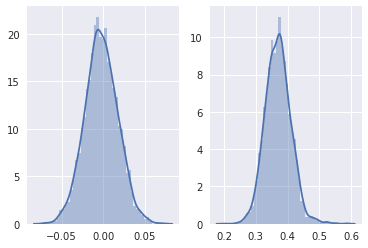

In [137]:
fig, axs = plt.subplots(1,2)
sns.distplot(X.mean(), ax=axs[0]);
sns.distplot(X.std(), ax=axs[1]);

#### What do the features look like?

**The features are strongly bimodal.** The usual summary statistics of mean, median and std are not appropriate for bimodal distributions.

If you were to randomly select a word, on average its feature representation would have 1.3% for an animal noun.

In [165]:
S.mean(axis=1).sort_values(ascending=False).head()

noun.artifact         0.100604
noun.person           0.081092
noun.act              0.066654
noun.communication    0.060680
verb.communication    0.050085
dtype: float64

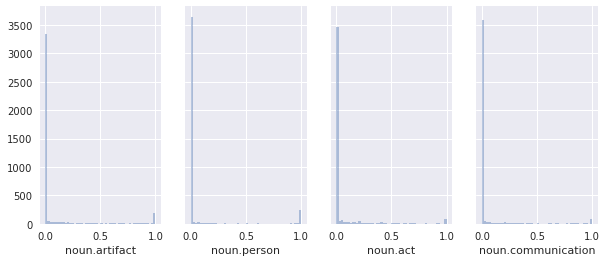

In [163]:
fig, axs = plt.subplots(ncols=4, figsize=(10, 4), sharey=True)
sns.distplot(S.loc['noun.artifact'], ax=axs[0], kde=False);
sns.distplot(S.loc['noun.person'], ax=axs[1], kde=False);
sns.distplot(S.loc['noun.act'], ax=axs[2], kde=False);
sns.distplot(S.loc['noun.communication'], ax=axs[3], kde=False);

#### What proportion of words in the vocab have a non-zero value for each feature?

On average across all 41 features, 6% of words have a nonzero entry for features. The highest proportion is 21%.

In [168]:
proportions = S.astype(bool).sum(axis=1) / len(S.columns)
print(proportions.sort_values(ascending=False).head())
proportions.describe()

noun.artifact         0.210702
noun.act              0.181796
noun.communication    0.151935
noun.person           0.135929
verb.communication    0.116579
dtype: float64


count    41.000000
mean      0.060783
std       0.048772
min       0.002628
25%       0.024606
50%       0.043717
75%       0.091495
max       0.210702
dtype: float64

#### How can I actually measure an association between linguistic features and learnt dimensions?

Knowing that the dimensions of the learnt embeddings are normally distributed and that the features are strongly bimodal, what is the best way to measure their correlation? It's clear that Pearson's $r$ and Spearman's $\rho$ are not appropriate because of the high number of ties.

I see two broad approaches:

- Remove all 0's and use Pearson's or Spearman's.
- Treat the feature as binary and compare means.

#### Remove 0's

Todo:
- Do the two things above in order to find a way to properly measure any association between linguistic features and learnt embeddings.
- Use better features (e.g. FrameNet)

In [186]:
S.head()

words,in,a,be,have,will,one,two,more,first,up,...,epiphysis,alveolus,antiserum,quirt,polyphosphate,catkin,illumine,thyroglobulin,pushup,compulsivity
noun.Tops,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
noun.act,0.181818,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.322581,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
noun.animal,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
noun.artifact,0.090909,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
noun.attribute,0.090909,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.032258,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [187]:
(S == 0).head()

words,in,a,be,have,will,one,two,more,first,up,...,epiphysis,alveolus,antiserum,quirt,polyphosphate,catkin,illumine,thyroglobulin,pushup,compulsivity
noun.Tops,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
noun.act,False,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,False,True
noun.animal,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
noun.artifact,False,True,True,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True,True,True,True
noun.attribute,False,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,False


#### Treat linguistic features as binary

One suggestion [here](https://stats.stackexchange.com/questions/102778/correlations-between-continuous-and-categorical-nominal-variables) is to 

In [175]:
S.astype(bool).astype(int).head()

words,in,a,be,have,will,one,two,more,first,up,...,epiphysis,alveolus,antiserum,quirt,polyphosphate,catkin,illumine,thyroglobulin,pushup,compulsivity
noun.Tops,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
noun.act,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
noun.animal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
noun.artifact,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
noun.attribute,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


#### How sparse is the feature matrix?

93% of the entries in the feature matrix are zero.

In [ ]:
(subset.size - np.count_nonzero(subset.values)) / subset.size

#### On average, how correlated are the dimensions with the linguistic features?

This plot suggests "not really". In fact it looks very normal. That is, on average there is **no** correlation between the dimensions of a word embedding and linguistic features.

This plot isn't that interesting. It's telling me the average of 40 numbers is normally distributed, which comes from CLT.

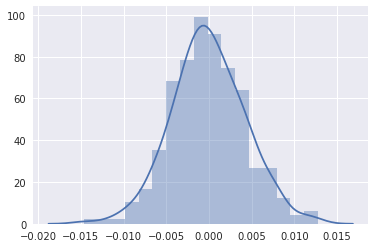

In [7]:
sns.distplot(correlations.mean(axis=1));

#### How correlated are the features and learnt dimensions?

This is a more meaningful plot. It says that the correlations are normally distributed around 0.

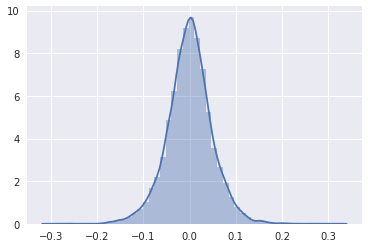

In [8]:
sns.distplot(correlations.values.flatten());

The following summary shows that the $(41*300)$ correlations are centered at 0 with std 0.05. The largest is 0.32, and the smallest is 0.30. These don't seem like very high numbers. The 75% percentile is 0.03. By looking back at the histogram above, it's obviously these dimensions are not highly correlated with these linguistic features.

Another important point from this is that the distribution of correlations is symmetric. So using the the max, rather than the max absolute, seems arbitrary. It doesn't allow for reversed dimensions.

In [9]:
pd.Series(correlations.values.flatten()).describe()

count    12300.000000
mean        -0.000063
std          0.048710
min         -0.298277
25%         -0.028078
50%          0.000444
75%          0.028427
max          0.318956
dtype: float64

#### What do the maximum correlations look like?

These are all positive. But are they different enough from 0? What test can I use here?

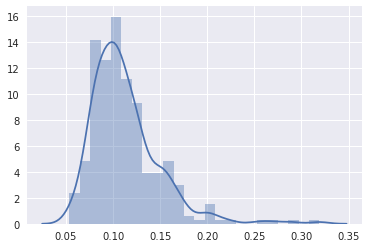

In [10]:
sns.distplot(correlations.max(axis=1));

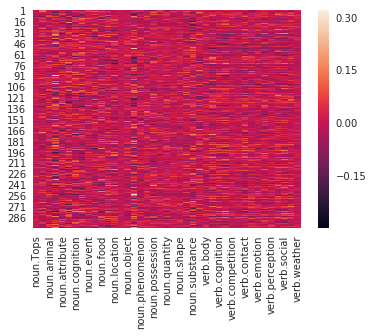

In [14]:
sns.heatmap(correlations);

## Todo
- Use different linguistic features (semantic, syntactic, etc.)
- Use different correlation metric
- Explore the correlations, alignments and top k words more
- Levin's verb classification

## Explore correlations, alignments and top k words

#### Top K words
In the paper they give the top K words for a dimension. The code prints, for each dimension, the dimension number, the aligned linguistic feature, the correlation between the two previous things, and the top k words associated with the dimension. I understand the last bit to mean "the k words with the highest value in the dimension".

In [ ]:
k = 50
top_k = pd.DataFrame(alignments, columns=['feature'])
top_k['correlation'] = correlations.max(axis=1)
tmp = pd.DataFrame([embeddings.loc[i].nlargest(n=k).index for i in top_k.index])
top_k = pd.merge(top_k, tmp, left_index=True, right_index=True)

top_k.head()

Most of these top words seem like junk. However, it'd be good to tease this apart a bit more. Here are some questions I'd like to ask:
- Are the top k words even of the right POS?
- Which features are missing (i.e. not the most correlated with any dimension)?
- How can I objectively measure whether the top k words are "correct"?

In [ ]:
def get_dims(feature, df=top_k):
    """Return the dimensions aligned with `feature` in `df`."""
    return df[df['feature']==feature]

get_dims('noun.animal')

#### Which features are not the most correlated with any dimension?

In [ ]:
subset.index.difference(top_k['feature'])

#### FrameNet

- What is the appropriate way to use FrameNet resources as features?

In [ ]:
from nltk.corpus import framenet as fn

fn.lus('happen.v')[1]

tagged_chunks[:20]